# Parquet Dataframe

## Short

In [10]:
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict, Counter
from pathlib import Path


data_dir = Path("./processed/finance/pair_in_7days_5minutes_out_1days_5minutes")
json_files = list(data_dir.glob("*.json"))

if not json_files:
    raise ValueError(f"No JSON files under {data_dir} directory")

all_data = []

for file in tqdm(json_files, desc="Loading & Parsing JSON Files"):
    try:
        with open(file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
            row = {
                "file_name": file.name,  # str
                "alignment": json_data.get("alignment"),  # str
                "input_window_len": len(json_data.get("input_window", [])),  # int
                "output_window_len": len(json_data.get("output_window", [])),  # int
                "input_timestamps": json_data.get("input_timestamps"),  # list
                "output_timestamps": json_data.get("output_timestamps"),  # list
                "input_window": json_data.get("input_window"),  # list
                "output_window": json_data.get("output_window"),  # list
                "text": json_data.get("text"),  # dict
                "trend": json_data.get("trend"),  # dict
                "technical": json_data.get("technical")  # dict
            }
            all_data.append(row)
            
    except Exception as e:
        print(f"Failed to load {file.name}: {str(e)}")
        continue


df = pd.DataFrame(all_data)

most_common_in_len = df['input_window_len'].value_counts().index[0]
most_common_out_len = df['output_window_len'].value_counts().index[0]
print(most_common_in_len, most_common_out_len)

df_aligned_consistent = df[(df['input_window_len']==390) & (df['output_window_len']==78) & (df['alignment']=='consistent')]
#df_aligned_consistent2 = df[(df['input_window_len']==143) & (df['output_window_len']==33) & (df['alignment']=='consistent')]
#df_aligned_consistent3 = df[(df['input_window_len']==134) & (df['output_window_len']==33) & (df['alignment']=='consistent')]

inconsitant_target_size = max(1, len(df_aligned_consistent) // 4)
df_aligned_inconsistent = df[(df['input_window_len']==390) & (df['output_window_len']==78) & (df['alignment']=='inconsistent')]
if len(df_aligned_inconsistent) <= inconsitant_target_size:
    df_inconsistent_sampled = df_aligned_inconsistent.copy()
else:
    df_inconsistent_sampled = df_aligned_inconsistent.sample(
        n=inconsitant_target_size, 
        random_state=42 
    )
df_combined = pd.concat(
    [df_aligned_consistent, df_inconsistent_sampled],
    ignore_index=True  
)

print(f"\n Data loaded successfully! Total rows: {len(df_combined)}")
#df_combined.to_parquet('./processed/finance/pair_in_7days_5minutes_out_1days_5minutes/finance_short.parquet')

Loading & Parsing JSON Files:   1%|          | 90/7420 [00:00<00:16, 439.98it/s]

Loading & Parsing JSON Files: 100%|██████████| 7420/7420 [00:19<00:00, 388.39it/s]

390 78

 Data loaded successfully! Total rows: 1400


In [12]:
df['output_window_len'].value_counts()

output_window_len
78    6534
53     127
77      83
47      61
79      53
      ... 
57       2
64       1
58       1
46       1
30       1
Name: count, Length: 76, dtype: int64

In [1]:
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict, Counter

# ========== 配置 ==========
data_dir = Path("./processed/finance/pair_in_7days_5minutes_out_1days_5minutes")
json_files = list(data_dir.glob("*.json"))

if not json_files:
    raise ValueError(f"No JSON files under {data_dir} directory")

all_data = []
TARGET_INPUT_LEN = 312   # 目标输入窗口长度
TARGET_OUTPUT_LEN = 78   # 目标输出窗口长度

# ========== 加载 & 过滤数据 ==========
for file in tqdm(json_files, desc="Loading & Parsing JSON Files"):
    try:
        with open(file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
            
            # 提取字段，缺失则默认空列表
            input_window = json_data.get("input_window", [])
            input_timestamps = json_data.get("input_timestamps", [])
            output_window = json_data.get("output_window", [])
            output_timestamps = json_data.get("output_timestamps", [])
            
            # 截断输入窗口为最后134个点（自动处理长度不足的情况）
            input_window = input_window[-TARGET_INPUT_LEN:]
            input_timestamps = input_timestamps[-TARGET_INPUT_LEN:]
            
            # ✅ 关键过滤：只保留输入=134 & 输出=33 的样本，其余跳过
            if len(input_window) != TARGET_INPUT_LEN or len(output_window) != TARGET_OUTPUT_LEN:
                continue  # 跳过不符合长度要求的样本
            
            # 可选：验证时间戳和窗口长度对齐（推荐保留）
            assert len(input_window) == len(input_timestamps), f"Input window/timestamps length mismatch in {file.name}"
            assert len(output_window) == len(output_timestamps), f"Output window/timestamps length mismatch in {file.name}"
            
            # 构造行数据
            row = {
                "file_name": file.name,
                "alignment": json_data.get("alignment"),  # str
                "input_window_len": len(input_window),    # 应为134
                "output_window_len": len(output_window),  # 应为33
                "input_timestamps": input_timestamps,
                "output_timestamps": output_timestamps,
                "input_window": input_window,
                "output_window": output_window,
                "text": json_data.get("text"),      # dict
                "trend": json_data.get("trend"),    # dict
                "technical": json_data.get("technical")  # dict
            }
            all_data.append(row)
            
    except Exception as e:
        print(f"Failed to load {file.name}: {str(e)}")
        continue

# ========== 构建 DataFrame ==========
df = pd.DataFrame(all_data)

if len(df) == 0:
    raise ValueError("No valid samples found after filtering by input=134 & output=33.")

# 安全计算最常见的长度（避免空值报错）
vc_in = df['input_window_len'].value_counts()
vc_out = df['output_window_len'].value_counts()
most_common_in_len = vc_in.index[0] if len(vc_in) > 0 else 0
most_common_out_len = vc_out.index[0] if len(vc_out) > 0 else 0

print(f"最常见输入窗口长度: {most_common_in_len}, 最常见输出窗口长度: {most_common_out_len}")

# ========== 按 alignment 分组采样 ==========
df_aligned_consistent1 = df[
    (df['input_window_len'] == TARGET_INPUT_LEN) &
    (df['output_window_len'] == TARGET_OUTPUT_LEN) &
    (df['alignment'] == 'consistent')
]

df_aligned_inconsistent = df[
    (df['input_window_len'] == TARGET_INPUT_LEN) &
    (df['output_window_len'] == TARGET_OUTPUT_LEN) &
    (df['alignment'] == 'inconsistent')
]

# 目标：inconsistent 样本数量为 consistent 的 1/4（至少1个）
inconsistent_target_size = max(1, len(df_aligned_consistent1) // 4)

# 安全采样：避免空DataFrame或样本不足时报错
if len(df_aligned_inconsistent) == 0:
    df_inconsistent_sampled = df_aligned_inconsistent  # 空DataFrame
elif len(df_aligned_inconsistent) <= inconsistent_target_size:
    df_inconsistent_sampled = df_aligned_inconsistent.copy()
else:
    df_inconsistent_sampled = df_aligned_inconsistent.sample(
        n=inconsistent_target_size, 
        random_state=42 
    )

# ========== 合并最终数据集 ==========
df_combined = pd.concat(
    [df_aligned_consistent1, df_inconsistent_sampled],
    ignore_index=True  
)

print(f"\n✅ Data loaded and filtered successfully!")
print(f"  - Total consistent samples: {len(df_aligned_consistent1)}")
print(f"  - Total inconsistent samples (sampled): {len(df_inconsistent_sampled)}")
print(f"  - Final combined dataset size: {len(df_combined)}")

# 可选：保存到 Parquet
#df_combined.to_parquet('./processed/finance/pair_in_7days_5minutes_out_1days_5minutes/finance_short.parquet')

/home/lige/miniconda3/envs/TS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading & Parsing JSON Files: 100%|██████████| 7420/7420 [00:18<00:00, 411.26it/s]

最常见输入窗口长度: 312, 最常见输出窗口长度: 78

✅ Data loaded and filtered successfully!
  - Total consistent samples: 1371
  - Total inconsistent samples (sampled): 342
  - Final combined dataset size: 1713


In [2]:
df_combined['output_bin_label'] = df_combined['trend'].apply(lambda x: x.get('output_bin_label') if isinstance(x, dict) else None)
up_categories = ['+2% ~ +4%', '>+4%']
target_up_count = df_combined[df_combined['output_bin_label'].isin(up_categories)].shape[0]  # 305 + 91 = 396
neutral_label = '-2% ~ +2%'
neutral_mask = df_combined['output_bin_label'] == neutral_label
current_neutral_count = neutral_mask.sum()  # 1193
target_neutral_count = min(target_up_count, current_neutral_count)  # 396

neutral_indices = df_combined[neutral_mask].index

if len(neutral_indices) > target_neutral_count:
    sampled_neutral_indices = np.random.RandomState(42).choice(
        neutral_indices, 
        size=target_neutral_count, 
        replace=False
    )
else:
    sampled_neutral_indices = neutral_indices

other_indices = df_combined[~neutral_mask].index

final_indices = np.concatenate([sampled_neutral_indices, other_indices])

df_balanced = df_combined.loc[final_indices].reset_index(drop=True)
df_balanced

,file_name,alignment,input_window_len,output_window_len,input_timestamps,output_timestamps,input_window,output_window,text,trend,technical,output_bin_label
0,129_JPM.json,consistent,312,78,"[1682530200.0, 1682530500.0, 1682530800.0, 168...","[1683048600.0, 1683048900.0, 1683049200.0, 168...","[137.62, 137.44, 137.11, 137.17, 137.13, 137.3...","[141.4, 141.63, 141.9, 141.61, 141.23, 140.93,...",{'content': 'Stock-market investors want the F...,{'input_percentage_change': -0.959812100506939...,"{'in_sma_10': [139.6, 139.6, 139.54, 139.4725,...",-2% ~ +2%
1,5959_GNRC.json,consistent,312,78,"[1656351000.0, 1656351300.0, 1656351600.0, 165...","[1656696600.0, 1656696900.0, 1656697200.0, 165...","[228.08, 227, 228.34, 225.75, 225.75, 228, 227...","[213.81, 214.96, 214.1769, 216.14, 219.2, 221....",{'content': 'Generac Holdings (GNRC) Dips More...,{'input_percentage_change': -2.004590318500629...,"{'in_sma_10': [223.0, 223.0, 222.7433333333333...",-2% ~ +2%
2,428_AMZN.json,consistent,312,78,"[1622661900.0, 1622662200.0, 1622662500.0, 162...","[1623180300.0, 1623180600.0, 1623180900.0, 162...","[161.312, 161.328, 161.216, 161.2636, 161.4575...","[162.3745, 162.7085, 162.612, 162.338, 162.683...",{'content': 'What’s the one skill all business...,{'input_percentage_change': -0.433334589708445...,"{'in_sma_10': [161.229, 161.2165, 161.2345, 16...",-2% ~ +2%
3,3637_JNJ.json,consistent,312,78,"[1673551800.0, 1673552100.0, 1673552400.0, 167...","[1674156600.0, 1674156900.0, 1674157200.0, 167...","[174.26, 173.105, 173.5257, 173.41, 173.26, 17...","[169.03, 169.9, 170.68, 170.64, 171.115, 170.7...",{'content': 'Johnson & Johnson (JNJ) Stock Mov...,{'input_percentage_change': -0.877142392593451...,"{'in_sma_10': [174.26, 173.6825, 173.630233333...",-2% ~ +2%
4,2726_WYNN.json,consistent,312,78,"[1675452600.0, 1675452900.0, 1675453200.0, 167...","[1675971000.0, 1675971300.0, 1675971600.0, 167...","[101.71, 102.11, 102.5394, 103.08, 103.475, 10...","[109.21, 109.41, 109.7258, 110.58, 110.995, 11...","{'content': 'Compared to Estimates, Wynn (WYNN...",{'input_percentage_change': -1.025056182817540...,"{'in_sma_10': [104.17, 104.1375, 103.771666666...",-2% ~ +2%
...,...,...,...,...,...,...,...,...,...,...,...,...
911,4119_GME.json,inconsistent,312,78,"[1638905400.0, 1638905700.0, 1638906000.0, 163...","[1639423800.0, 1639424100.0, 1639424400.0, 163...","[43.795, 43.8125, 43.74, 43.4975, 43.5775, 43....","[40.0825, 39.25, 38.64, 39.0175, 38.4525, 37.7...",{'content': 'These 5 Coins Struck Big Gains La...,{'input_percentage_change': 0.1713469261661952...,"{'in_sma_10': [41.5, 42.0, 41.958333333333336,...",<-4%
912,5248_AGIO.json,inconsistent,312,78,"[1645039800.0, 1645040100.0, 1645040340.0, 164...","[1645644600.0, 1645644900.0, 1645645260.0, 164...","[30.81, 31.3, 30.92, 30.91, 30.875, 30.39, 30....","[29.11, 29.16, 29.17, 29.34, 29.2, 28.98, 28.9...",{'content': 'Agios Pharmaceuticals With FDA Ap...,{'input_percentage_change': -3.264118792599783...,"{'in_sma_10': [30.81, 31.055, 31.01, 30.985, 3...",-2% ~ -4%
913,5704_VIPS.json,inconsistent,312,78,"[1666287000.0, 1666287300.0, 1666287600.0, 166...","[1666805400.0, 1666805700.0, 1666806000.0, 166...","[7.5, 7.44, 7.405, 7.49, 7.53, 7.58, 7.61, 7.6...","[7.12, 7.1599, 7.31, 7.195, 7.295, 7.225, 7.25...",{'content': 'Vipshop Holdings Limited (VIPS) G...,{'input_percentage_change': -4.985880611077454...,"{'in_sma_10': [7.62, 7.705, 7.71, 7.71, 7.696,...",>+4%
914,2943_MSFT.json,inconsistent,312,78,"[1657128600.0, 1657128900.0, 1657129200.0, 165...","[1657647000.0, 1657647300.0, 1657647600.0, 165...","[263.75, 263.765, 263.26, 264.31, 263.35, 264....","[265.88, 264.75, 264.27, 263.145, 260.96, 260....",{'content': 'Microsoft (MSFT) Dips More Than B...,{'input_percentage_change': 3.2683075681865263...,"{'in_sma_10': [256.16, 255.66000000000003, 255...",-2% ~ -4%


In [21]:
#df_balanced['alignment'].value_counts()
sample_means = df_balanced['input_window'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
print(sample_means.describe())

count     916.000000
mean      117.577773
std       184.953007
min         1.197646
25%        30.225126
50%        68.944320
75%       143.817250
max      2686.191158
Name: input_window, dtype: float64


In [3]:
lis = []
for i in range(len(df_balanced)):
    lis.append(df_balanced['trend'][i]['output_bin_label'])
lis = pd.Series(lis)
lis.value_counts()

-2% ~ +2%    396
+2% ~ +4%    305
>+4%          91
-2% ~ -4%     80
<-4%          44
Name: count, dtype: int64

In [5]:
df_balanced.to_parquet('./processed/finance/pair_in_7days_5minutes_out_1days_5minutes/finance_short.parquet')

## Long

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict, Counter

# ========== 配置 ==========
data_dir = Path("./processed/finance/pair_in_30days_1hours_out_7days_1hours")
json_files = list(data_dir.glob("*.json"))

if not json_files:
    raise ValueError(f"No JSON files under {data_dir} directory")

all_data = []
TARGET_INPUT_LEN = 134   # 目标输入窗口长度
TARGET_OUTPUT_LEN = 33   # 目标输出窗口长度

# ========== 加载 & 过滤数据 ==========
for file in tqdm(json_files, desc="Loading & Parsing JSON Files"):
    try:
        with open(file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
            
            # 提取字段，缺失则默认空列表
            input_window = json_data.get("input_window", [])
            input_timestamps = json_data.get("input_timestamps", [])
            output_window = json_data.get("output_window", [])
            output_timestamps = json_data.get("output_timestamps", [])
            
            # 截断输入窗口为最后134个点（自动处理长度不足的情况）
            input_window = input_window[-TARGET_INPUT_LEN:]
            input_timestamps = input_timestamps[-TARGET_INPUT_LEN:]
            
            # ✅ 关键过滤：只保留输入=134 & 输出=33 的样本，其余跳过
            if len(input_window) != TARGET_INPUT_LEN or len(output_window) != TARGET_OUTPUT_LEN:
                continue  # 跳过不符合长度要求的样本
            
            # 可选：验证时间戳和窗口长度对齐（推荐保留）
            assert len(input_window) == len(input_timestamps), f"Input window/timestamps length mismatch in {file.name}"
            assert len(output_window) == len(output_timestamps), f"Output window/timestamps length mismatch in {file.name}"
            
            # 构造行数据
            row = {
                "file_name": file.name,
                "alignment": json_data.get("alignment"),  # str
                "input_window_len": len(input_window),    # 应为134
                "output_window_len": len(output_window),  # 应为33
                "input_timestamps": input_timestamps,
                "output_timestamps": output_timestamps,
                "input_window": input_window,
                "output_window": output_window,
                "text": json_data.get("text"),      # dict
                "trend": json_data.get("trend"),    # dict
                "technical": json_data.get("technical")  # dict
            }
            all_data.append(row)
            
    except Exception as e:
        print(f"Failed to load {file.name}: {str(e)}")
        continue

# ========== 构建 DataFrame ==========
df = pd.DataFrame(all_data)

if len(df) == 0:
    raise ValueError("No valid samples found after filtering by input=134 & output=33.")

# 安全计算最常见的长度（避免空值报错）
vc_in = df['input_window_len'].value_counts()
vc_out = df['output_window_len'].value_counts()
most_common_in_len = vc_in.index[0] if len(vc_in) > 0 else 0
most_common_out_len = vc_out.index[0] if len(vc_out) > 0 else 0

print(f"最常见输入窗口长度: {most_common_in_len}, 最常见输出窗口长度: {most_common_out_len}")

# ========== 按 alignment 分组采样 ==========
df_aligned_consistent1 = df[
    (df['input_window_len'] == TARGET_INPUT_LEN) &
    (df['output_window_len'] == TARGET_OUTPUT_LEN) &
    (df['alignment'] == 'consistent')
]

df_aligned_inconsistent = df[
    (df['input_window_len'] == TARGET_INPUT_LEN) &
    (df['output_window_len'] == TARGET_OUTPUT_LEN) &
    (df['alignment'] == 'inconsistent')
]

# 目标：inconsistent 样本数量为 consistent 的 1/4（至少1个）
inconsistent_target_size = max(1, len(df_aligned_consistent1) // 4)

# 安全采样：避免空DataFrame或样本不足时报错
if len(df_aligned_inconsistent) == 0:
    df_inconsistent_sampled = df_aligned_inconsistent  # 空DataFrame
elif len(df_aligned_inconsistent) <= inconsistent_target_size:
    df_inconsistent_sampled = df_aligned_inconsistent.copy()
else:
    df_inconsistent_sampled = df_aligned_inconsistent.sample(
        n=inconsistent_target_size, 
        random_state=42 
    )

# ========== 合并最终数据集 ==========
df_combined = pd.concat(
    [df_aligned_consistent1, df_inconsistent_sampled],
    ignore_index=True  
)

print(f"\n✅ Data loaded and filtered successfully!")
print(f"  - Total consistent samples: {len(df_aligned_consistent1)}")
print(f"  - Total inconsistent samples (sampled): {len(df_inconsistent_sampled)}")
print(f"  - Final combined dataset size: {len(df_combined)}")

# 可选：保存到 Parquet
#df_combined.to_parquet('./processed/finance/pair_in_30days_1hours_out_7days_1hours/finance_long.parquet')

Loading & Parsing JSON Files:   7%|▋         | 592/8031 [00:00<00:09, 824.38it/s]

Failed to load 5551_EXLS.json: Input window/timestamps length mismatch in 5551_EXLS.json


Loading & Parsing JSON Files:  11%|█▏        | 922/8031 [00:01<00:08, 813.67it/s]

Failed to load 2853_TM.json: Input window/timestamps length mismatch in 2853_TM.json


Loading & Parsing JSON Files:  21%|██        | 1665/8031 [00:02<00:07, 808.28it/s]

Failed to load 4898_TM.json: Input window/timestamps length mismatch in 4898_TM.json
Failed to load 1705_BKH.json: Input window/timestamps length mismatch in 1705_BKH.json
Failed to load 4760_MRTN.json: Input window/timestamps length mismatch in 4760_MRTN.json


Loading & Parsing JSON Files:  24%|██▍       | 1912/8031 [00:02<00:07, 789.60it/s]

Failed to load 700_KRO.json: Input window/timestamps length mismatch in 700_KRO.json
Failed to load 7497_CMG.json: Input window/timestamps length mismatch in 7497_CMG.json
Failed to load 6662_CMG.json: Input window/timestamps length mismatch in 6662_CMG.json


Loading & Parsing JSON Files:  28%|██▊       | 2242/8031 [00:02<00:07, 804.31it/s]

Failed to load 4247_MTW.json: Input window/timestamps length mismatch in 4247_MTW.json
Failed to load 409_CMG.json: Input window/timestamps length mismatch in 409_CMG.json


Loading & Parsing JSON Files:  32%|███▏      | 2565/8031 [00:03<00:05, 983.95it/s]

Failed to load 7275_E.json: Input window/timestamps length mismatch in 7275_E.json
Failed to load 6981_SEIC.json: Input window/timestamps length mismatch in 6981_SEIC.json
Failed to load 1611_TDG.json: Input window/timestamps length mismatch in 1611_TDG.json
Failed to load 5295_ENSG.json: Input window/timestamps length mismatch in 5295_ENSG.json
Failed to load 4418_WLK.json: Input window/timestamps length mismatch in 4418_WLK.json


Loading & Parsing JSON Files:  36%|███▌      | 2883/8031 [00:03<00:04, 1031.30it/s]

Failed to load 1748_RHP.json: Input window/timestamps length mismatch in 1748_RHP.json
Failed to load 3889_SAH.json: Input window/timestamps length mismatch in 3889_SAH.json
Failed to load 1802_MSCI.json: Input window/timestamps length mismatch in 1802_MSCI.json


Loading & Parsing JSON Files:  41%|████▏     | 3324/8031 [00:03<00:04, 1079.30it/s]

Failed to load 4341_LSTR.json: Input window/timestamps length mismatch in 4341_LSTR.json


Loading & Parsing JSON Files:  48%|████▊     | 3874/8031 [00:04<00:03, 1088.60it/s]

Failed to load 4176_VRA.json: Input window/timestamps length mismatch in 4176_VRA.json
Failed to load 5892_COO.json: Input window/timestamps length mismatch in 5892_COO.json


Loading & Parsing JSON Files:  51%|█████     | 4091/8031 [00:04<00:03, 1067.53it/s]

Failed to load 5340_HLIT.json: Input window/timestamps length mismatch in 5340_HLIT.json
Failed to load 6700_BDC.json: Input window/timestamps length mismatch in 6700_BDC.json
Failed to load 391_BCC.json: Input window/timestamps length mismatch in 391_BCC.json


Loading & Parsing JSON Files:  63%|██████▎   | 5078/8031 [00:05<00:02, 1059.65it/s]

Failed to load 912_WTFC.json: Input window/timestamps length mismatch in 912_WTFC.json
Failed to load 5927_NSIT.json: Input window/timestamps length mismatch in 5927_NSIT.json
Failed to load 1382_PRGS.json: Input window/timestamps length mismatch in 1382_PRGS.json


Loading & Parsing JSON Files:  66%|██████▌   | 5296/8031 [00:05<00:02, 1072.85it/s]

Failed to load 7019_VRA.json: Input window/timestamps length mismatch in 7019_VRA.json


Loading & Parsing JSON Files:  68%|██████▊   | 5501/8031 [00:05<00:02, 862.99it/s] 

Failed to load 2404_VECO.json: Input window/timestamps length mismatch in 2404_VECO.json


Loading & Parsing JSON Files:  71%|███████   | 5677/8031 [00:06<00:02, 784.95it/s]

Failed to load 3746_CASY.json: Input window/timestamps length mismatch in 3746_CASY.json
Failed to load 2163_CONN.json: Input window/timestamps length mismatch in 2163_CONN.json


Loading & Parsing JSON Files:  75%|███████▍  | 6010/8031 [00:06<00:02, 811.59it/s]

Failed to load 6520_CBU.json: Input window/timestamps length mismatch in 6520_CBU.json
Failed to load 3929_ASH.json: Input window/timestamps length mismatch in 3929_ASH.json


Loading & Parsing JSON Files:  80%|████████  | 6438/8031 [00:06<00:01, 995.50it/s]

Failed to load 2521_EXG.json: Input window/timestamps length mismatch in 2521_EXG.json
Failed to load 7657_BZH.json: Input window/timestamps length mismatch in 7657_BZH.json
Failed to load 3707_CMRE.json: Input window/timestamps length mismatch in 3707_CMRE.json


Loading & Parsing JSON Files:  87%|████████▋ | 6968/8031 [00:07<00:01, 1005.99it/s]

Failed to load 2523_HAE.json: Input window/timestamps length mismatch in 2523_HAE.json
Failed to load 3198_FFBC.json: Input window/timestamps length mismatch in 3198_FFBC.json


Loading & Parsing JSON Files:  89%|████████▉ | 7185/8031 [00:07<00:00, 1026.16it/s]

Failed to load 766_HT.json: Input window/timestamps length mismatch in 766_HT.json


Loading & Parsing JSON Files:  92%|█████████▏| 7386/8031 [00:07<00:00, 918.61it/s] 

Failed to load 1838_TFX.json: Input window/timestamps length mismatch in 1838_TFX.json


Loading & Parsing JSON Files:  94%|█████████▍| 7567/8031 [00:08<00:00, 861.70it/s]

Failed to load 5222_AWI.json: Input window/timestamps length mismatch in 5222_AWI.json
Failed to load 2840_ITT.json: Input window/timestamps length mismatch in 2840_ITT.json
Failed to load 3286_SPTN.json: Input window/timestamps length mismatch in 3286_SPTN.json


Loading & Parsing JSON Files: 100%|██████████| 8031/8031 [00:08<00:00, 924.60it/s]

Failed to load 1409_DEO.json: Input window/timestamps length mismatch in 1409_DEO.json
最常见输入窗口长度: 134, 最常见输出窗口长度: 33



✅ Data loaded and filtered successfully!
  - Total consistent samples: 1167
  - Total inconsistent samples (sampled): 291
  - Final combined dataset size: 1458


In [16]:
#df['input_window_len'].value_counts()
#df['output_window_len'].value_counts()
#df[df['alignment'] == 'consistent']['input_window_len'].value_counts()
df_combined

,file_name,alignment,input_window_len,output_window_len,input_timestamps,output_timestamps,input_window,output_window,text,trend,technical
0,20_FANG.json,consistent,134,33,"[1677798000.0, 1677801600.0, 1677805200.0, 167...","[1680284100.0, 1680287700.0, 1680291300.0, 168...","[143.5, 143.1, 143.76, 142, 142.9, 144.3, 145....","[134.03, 134.775, 135.08, 134.91, 134.6431, 13...",{'content': 'Can Value Investors Select Diamon...,"{'input_percentage_change': -4.7425456989886, ...","{'in_sma_10': [140.29, 141.51, 142.05666666666..."
1,6347_INTC.json,consistent,134,33,"[1677794400.0, 1677798000.0, 1677801600.0, 167...","[1680283800.0, 1680287400.0, 1680291000.0, 168...","[25.33, 25.395, 25.77, 26.06, 26.2, 26.24, 26....","[31.8, 32.41, 32.655, 32.765, 32.795, 32.74, 3...",{'content': 'Intel Corporation (INTC) is Attra...,"{'input_percentage_change': 11.8173576323796, ...","{'in_sma_10': [25.03, 25.285, 25.2750000000000..."
2,1025_TGT.json,consistent,134,33,"[1689718500.0, 1689722100.0, 1689788700.0, 168...","[1692215100.0, 1692218700.0, 1692222300.0, 169...","[130.8, 130.76, 130.9, 131.7975, 132.06, 131.9...","[128.52, 129.445, 129.5, 129.4, 128.25, 132.31...",{'content': 'Here's why Target removed Pride-r...,{'input_percentage_change': 1.6805006975862014...,"{'in_sma_10': [130.52, 130.305, 130.1866666666..."
3,3550_ROST.json,consistent,134,33,"[1651783500.0, 1651787100.0, 1651790700.0, 165...","[1654536600.0, 1654540200.0, 1654543800.0, 165...","[99.17, 100.28, 99.29, 99.36, 96.48, 96.32, 95...","[82.92, 82.56, 81.93, 81.59, 81.61, 81.25, 81....",{'content': 'Why Ross Stores Lost 15% in May B...,{'input_percentage_change': -12.18163668899628...,"{'in_sma_10': [99.17, 99.725, 99.58, 99.525, 9..."
4,7951_PEP.json,consistent,134,33,"[1663104300.0, 1663107900.0, 1663111500.0, 166...","[1665600900.0, 1665604500.0, 1665608100.0, 166...","[170.27, 169.19, 168.05, 168.44, 168.58, 168.4...","[170.175, 169.76, 169.34, 168.86, 169.21, 169....",{'content': 'September PPI Data Higher-Than-Ex...,{'input_percentage_change': -4.150479596800461...,"{'in_sma_10': [174.09, 173.91500000000002, 173..."
...,...,...,...,...,...,...,...,...,...,...,...
1453,2175_IVR.json,inconsistent,134,33,"[1638304200.0, 1638307800.0, 1638311400.0, 163...","[1640822400.0, 1640826000.0, 1640892600.0, 164...","[30.25, 29.962, 29.8, 29.8, 29.75, 29.95, 30.0...","[28.5, 28.6, 28.7, 28.95, 28.95, 28.95, 28.85,...",{'content': 'Is the Options Market Predicting ...,{'input_percentage_change': -3.637851247555004...,"{'in_sma_10': [30.6, 30.625, 30.58333333333333..."
1454,7056_JPM.json,inconsistent,134,33,"[1631649600.0, 1631653200.0, 1631656800.0, 163...","[1634146200.0, 1634149800.0, 1634153400.0, 163...","[157.56, 157.2, 157.07, 156.63, 156.72, 156.84...","[164.07, 161.23, 161.42, 161.31, 161.07, 160.9...",{'content': 'JPMorgan Chase & Co. (JPM) Surpas...,{'input_percentage_change': 2.8340791864415156...,"{'in_sma_10': [158.53, 158.91, 159.10999999999..."
1455,609_SLG.json,inconsistent,134,33,"[1626984000.0, 1626987600.0, 1626991200.0, 162...","[1629480600.0, 1629484200.0, 1629487800.0, 162...","[77.22, 76.6941, 76.8745, 76.725, 77.9831, 75....","[71.9503, 71.3006, 71.2594, 71.6822, 72.1875, ...",{'content': 'SL Green Realty Corp. Announces C...,"{'input_percentage_change': -4.96783853272645,...","{'in_sma_10': [79.8084, 80.48645, 80.573266666..."
1456,5409_ABBV.json,inconsistent,134,33,"[1661200200.0, 1661203800.0, 1661207400.0, 166...","[1663781400.0, 1663785000.0, 1663788600.0, 166...","[140.95, 140.8, 140.28, 140.251, 138.625, 138....","[142.15, 143.21, 142.49, 142.9, 142.95, 141.84...",{'content': 'Is Trending Stock AbbVie Inc. (AB...,{'input_percentage_change': -1.875118059793681...,"{'in_sma_10': [141.97, 141.385, 141.1633333333..."


In [17]:
lis = []
for i in range(len(df_combined)):
    lis.append(df_combined['trend'][i]['output_bin_label'])
lis = pd.Series(lis)
lis.value_counts()

-2% ~ +2%    609
+2% ~ +4%    406
>+4%         250
-2% ~ -4%    102
<-4%          91
Name: count, dtype: int64

In [14]:
df_combined['technical'][0].keys()

dict_keys(['in_sma_10', 'in_sma_50', 'in_sma_200', 'in_ema_10', 'in_ema_50', 'in_ema_200', 'in_macd', 'in_signal', 'in_upper_bb', 'in_lower_bb', 'out_sma_10', 'out_sma_50', 'out_sma_200', 'out_ema_10', 'out_ema_50', 'out_ema_200', 'out_macd', 'out_signal', 'out_upper_bb', 'out_lower_bb', 'overall_sma_10', 'overall_sma_50', 'overall_sma_200', 'overall_ema_10', 'overall_ema_50', 'overall_ema_200', 'overall_macd', 'overall_signal', 'overall_upper_bb', 'overall_lower_bb'])

# Test Toech Dataset Builder

In [18]:
class FinanceDataset(Dataset):
    def __init__(self, 
                 data_dir, 
                 tokenizer, 
                 input_len=134,   #390
                 output_len=33, #78
                 max_text_length=2048,
                 pad_value=0.0):  
        self.data_dir = Path(data_dir)
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length
        self.pad_value = pad_value
        self.input_len = input_len
        self.output_len = output_len
        self.samples = []

        self._load_data()

    def _load_data(self):
        df_paths = list(self.data_dir.glob("*.parquet"))
        if not df_paths:
            raise ValueError(f"Parquet file does not exists under {self.data_dir} directory")
        df_path = df_paths[0]  

        try:
            df = pd.read_parquet(path=df_path, engine="pyarrow")
            tqdm.write(f"Loaded: {df_path.name}, {len(df)} original samples in total")
        except Exception as e:
            raise ValueError(f"Load {df_path.name} fails: {str(e)}")

        
        samples = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
            try:
                required_fields = ['input_window', 'output_window', 'text', 'input_timestamps', 'output_timestamps', 'trend', 'technical']
                for field in required_fields:
                    if field not in row:
                        raise KeyError(f"Sample {idx} Missing Key: {field}")
                    
                input_window = torch.tensor(row['input_window'], dtype=torch.float32)
                output_window = torch.tensor(row['output_window'], dtype=torch.float32)

                text_data = row['text']['content']
                text_tokens = self.tokenizer(
                    text_data,
                    max_length=self.max_text_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
                input_ids = text_tokens["input_ids"].squeeze(0)
                attention_mask = text_tokens["attention_mask"].squeeze(0)

                technical_data = row.get('technical', {})
                if not isinstance(technical_data, dict):
                    technical_data = {}  # safe loading of an errored case

                trend = row.get('trend', {})
                input_trend = trend['input_bin_label']
                output_trend = trend['output_bin_label']
                overall_trend = trend['overall_bin_label']

            except Exception as e:
                tqdm.write(f"Warning: Sample{idx}fails. Error: {str(e)}")
                continue
        

            input_ids = text_tokens["input_ids"].squeeze(0)
            attention_mask = text_tokens["attention_mask"].squeeze(0)

            samples.append({
                "input_timestamps": np.array(row['input_timestamps']),
                "output_timestamps": np.array(row['output_timestamps']),
                "input_window": input_window ,  
                "output_window": output_window,  
                "text_input_ids": input_ids,  
                "text_attention_mask": attention_mask,  
                "technical": technical_data, 
                "input_trend": input_trend,
                "output_trend": output_trend,
                "overall_trend": overall_trend,
            })

        self.samples = samples
        if not self.samples:
            raise ValueError("No valid samples loaded")

        tqdm.write(f"\nFinished dataset preparation")
        tqdm.write(f"Number of valid samples: {len(self.samples)}, input_len: {self.input_len}, output_len: {self.output_len}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self.samples):
            raise IndexError(f"Index {idx} out of range(total_num: {len(self.samples)})")
        return self.samples[idx]

In [19]:
llm_path = "../llm/Qwen1.5-MoE-A2.7B"
data_dir = Path("./processed/finance/pair_in_30days_1hours_out_7days_1hours")

tokenizer = AutoTokenizer.from_pretrained(llm_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id  

ds = FinanceDataset(data_dir=data_dir, tokenizer=tokenizer)
ds

Loaded: finance_long.parquet, 1458 original samples in total


Processing: 100%|██████████| 1458/1458 [00:04<00:00, 295.06it/s]


Finished dataset preparation
Number of valid samples: 1458, input_len: 134, output_len: 33


# Full Test

In [20]:
import matplotlib.pyplot as plt

def plot_series(filename, input_ts, output_ts, predicted_ts):#, save_folder):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(input_ts)), input_ts, label="Input Time Series")#, marker='o')
    plt.plot(range(len(input_ts), len(input_ts) + len(output_ts)), output_ts, label="Ground Truth")#, marker='o')
    plt.plot(range(len(input_ts), len(input_ts) + len(predicted_ts)), predicted_ts, label="Predicted", linestyle='dashed')
    plt.legend()
    plt.title(f"Prediction for {filename}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.grid()
    #plt.savefig(os.path.join(save_folder, filename.replace('.json', '.png')))
    plt.show()


In [ ]:
from dataset import FinanceDataset
from transformers import AutoTokenizer
from pathlib import Path


#data_dir = Path("./processed/finance/pair_in_7days_5minutes_out_1days_5minutes")
llm_path = "../llm/Qwen1.5-MoE-A2.7B"

tokenizer = AutoTokenizer.from_pretrained(llm_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id  

ds = FinanceDataset(data_dir=data_dir, tokenizer=tokenizer)

/home/lige/miniconda3/envs/TS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded: finance_short.parquet, 1400 original samples in total


Processing: 100%|██████████| 1400/1400 [00:04<00:00, 344.31it/s]


Finished dataset preparation
Number of valid samples: 1400, input_len: 390, output_len: 78


dict_keys(['input_timestamps', 'output_timestamps', 'input_window', 'output_window', 'text_input_ids', 'text_attention_mask', 'technical', 'input_trend', 'output_trend', 'overall_trend'])
>+4% +2% ~ +4%
Intel Corporation (INTC) is Attracting Investor Attention: Here is What You Should Know
By Zacks Equity Research
Published on: 2023-03-31T13:00:11Z

Zacks.com users have recently been watching Intel (INTC) quite a bit. Thus, it is worth knowing the facts that could determine the stock's prospects.

Article Content:

INTC Quick QuoteINTC
Intel (INTC Quick QuoteINTC  -  Free Report)     has been one of the most searched-for stocks on Zacks.com lately. So, you might want to look at some of the facts that could shape the stock's performance in the near term.
Shares of this world's largest chipmaker have returned +22.5% over the past month versus the Zacks S&P 500 composite's +2.3% change. The Zacks Semiconductor - General industry, to which Intel belongs, has gained 17% over this period. No

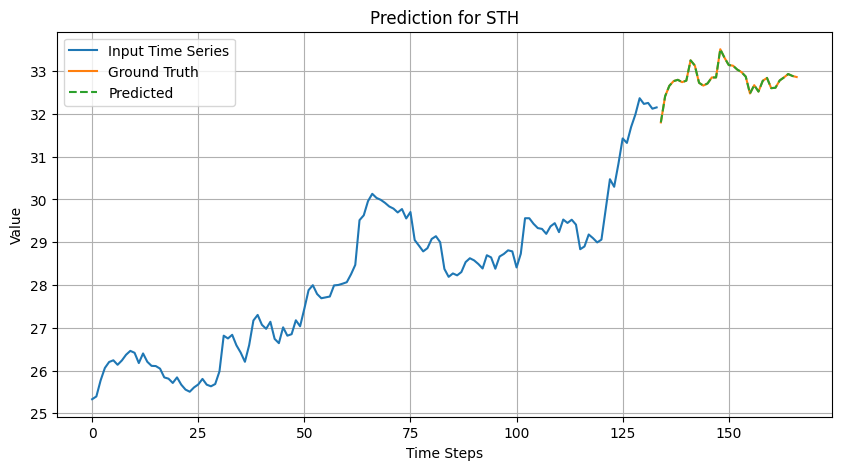

In [22]:
sample = ds[1]
print(sample.keys())
print(sample['input_trend'], sample['output_trend'])
print(tokenizer.decode(sample['text_input_ids'], skip_special_tokens=True))

plot_series("STH", sample['input_window'], sample['output_window'], sample['output_window'])

# Check Test Loader

In [ ]:
import random   
from dataloader import build_loader_from_saved
random.seed(7)

#data_dir = Path("./processed/finance/pair_in_7days_5minutes_out_1days_5minutes")
llm_path = "../llm/Qwen1.5-MoE-A2.7B"
data_pkl_dir = "./data/saved_datasets/finance_forecasting"
data_suffix = "in30_out7"


tokenizer = AutoTokenizer.from_pretrained(llm_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id  


dataset = FinanceDataset(
        data_dir=data_dir,
        tokenizer=tokenizer,
        input_len=134, #390
        output_len=33,  #78
        max_text_length=2048
        )

    
train_loader, _, test_loader = build_loader_from_saved(dataset=dataset, batch_size=1, num_workers=0,
                                                       train_ratio=0.8,val_ratio=0.0, seed=7, 
                                                       save_dir=data_pkl_dir, suffix=data_suffix)

ImportError: attempted relative import with no known parent package